🚗 We are dealing with a dataset about cars and we would like to predict whether a car is expensive or cheap.
Description: https://wagon-public-datasets.s3.amazonaws.com/Machine%20Learning%20Datasets/ML_Cars_dataset_description.txt

In [176]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.inspection import permutation_importance
# Checking whether a numerical feature has a normal distribution or not
from statsmodels.graphics.gofplots import qqplot

In [95]:
url = "https://wagon-public-datasets.s3.amazonaws.com/Machine%20Learning%20Datasets/ML_Cars_dataset.csv"

In [96]:
df = pd.read_csv(url)
df.head()

,aspiration,enginelocation,carwidth,curbweight,enginetype,cylindernumber,stroke,peakrpm,price
0,std,front,64.1,2548,dohc,four,2.68,5000,expensive
1,std,front,64.1,2548,dohc,four,2.68,5000,expensive
2,std,front,65.5,2823,ohcv,six,3.47,5000,expensive
3,std,front,NaN,2337,ohc,four,3.40,5500,expensive
4,std,front,66.4,2824,ohc,five,3.40,5500,expensive


## (1) Duplicates

In [97]:
df.shape

(205, 9)

In [98]:
print(df.duplicated().sum())
df = df.drop_duplicates()
print(df.duplicated().sum())

14
0


In [99]:
df.shape

(191, 9)

## (2) Missing values

In [100]:
df.describe()

,curbweight,stroke,peakrpm
count,191.000000,191.000000,191.000000
mean,2573.204188,3.259607,5113.089005
std,525.724187,0.317996,471.879096
min,1488.000000,2.070000,4150.000000
25%,2190.500000,3.110000,4800.000000
50%,2443.000000,3.290000,5100.000000
75%,2964.500000,3.410000,5500.000000
max,4066.000000,4.170000,6600.000000


In [101]:
df.isnull().sum().sort_values(ascending=False) / len(df)

enginelocation    0.052356
carwidth          0.010471
aspiration        0.000000
curbweight        0.000000
enginetype        0.000000
cylindernumber    0.000000
stroke            0.000000
peakrpm           0.000000
price             0.000000
dtype: float64

In [102]:
# tratando enginelocation
mf_imputer = SimpleImputer(strategy='most_frequent')
df[['enginelocation']] = mf_imputer.fit_transform(df[['enginelocation']])

df.isnull().sum().sort_values(ascending=False) / len(df)

carwidth          0.010471
aspiration        0.000000
enginelocation    0.000000
curbweight        0.000000
enginetype        0.000000
cylindernumber    0.000000
stroke            0.000000
peakrpm           0.000000
price             0.000000
dtype: float64

In [103]:
df['carwidth'].unique()

array(['64.1', '65.5', nan, '66.4', '66.3', '71.4', '67.9', '64.8',
       '66.9', '70.9', '60.3', '*', '63.6', '63.8', '64.6', '63.9', '64',
       '65.2', '66', '61.8', '69.6', '70.6', '64.2', '65.7', '66.5',
       '66.1', '70.3', '71.7', '70.5', '72', '68', '64.4', '65.4', '68.4',
       '68.3', '65', '72.3', '66.6', '63.4', '65.6', '67.7', '67.2',
       '68.9', '68.8'], dtype=object)

In [104]:
df['carwidth'] = df['carwidth'].replace('*', np.nan)

In [105]:
# carwidth
cw_imputer = SimpleImputer(strategy='median')
df[['carwidth']] = cw_imputer.fit_transform(df[['carwidth']])

df.isnull().sum().sort_values(ascending=False) / len(df)

aspiration        0.0
enginelocation    0.0
carwidth          0.0
curbweight        0.0
enginetype        0.0
cylindernumber    0.0
stroke            0.0
peakrpm           0.0
price             0.0
dtype: float64

## (3) Scaling the numerical features

In [106]:
# As a reminder, some information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 191 entries, 0 to 204
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   aspiration      191 non-null    object 
 1   enginelocation  191 non-null    object 
 2   carwidth        191 non-null    float64
 3   curbweight      191 non-null    int64  
 4   enginetype      191 non-null    object 
 5   cylindernumber  191 non-null    object 
 6   stroke          191 non-null    float64
 7   peakrpm         191 non-null    int64  
 8   price           191 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 14.9+ KB


In [107]:
numerical_features = df.select_dtypes(exclude=['object']).columns
numerical_features

Index(['carwidth', 'curbweight', 'stroke', 'peakrpm'], dtype='object')

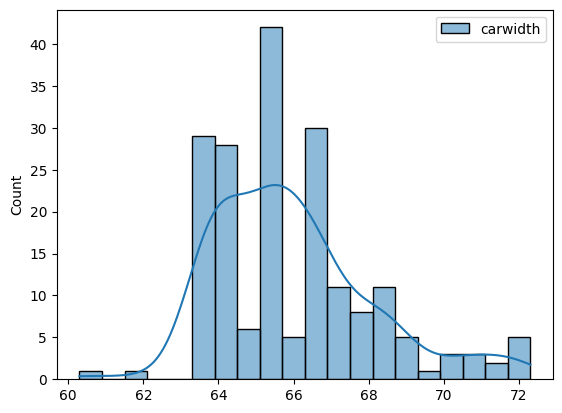

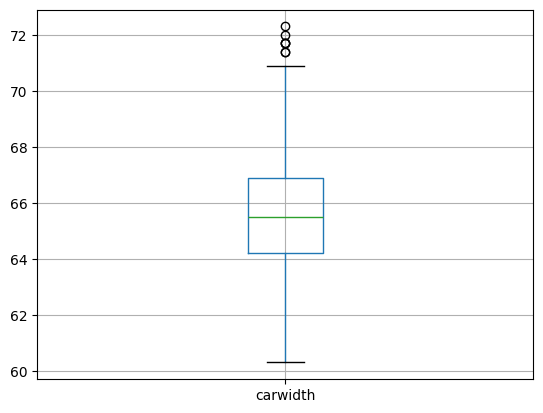

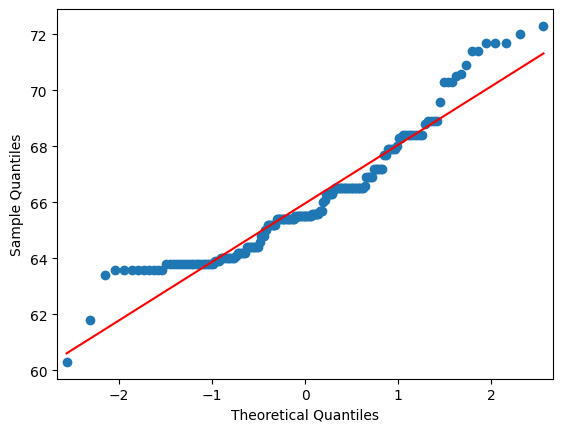

In [108]:
# carwidth
sns.histplot(df[['carwidth']], bins=20, kde=True)
plt.show()

df[['carwidth']].boxplot()
plt.show()

qqplot(df['carwidth'], line='s')
plt.show()

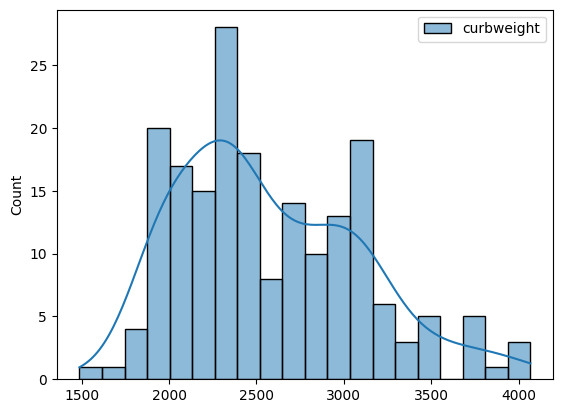

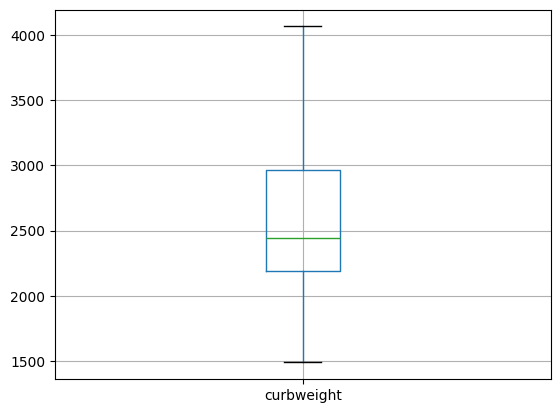

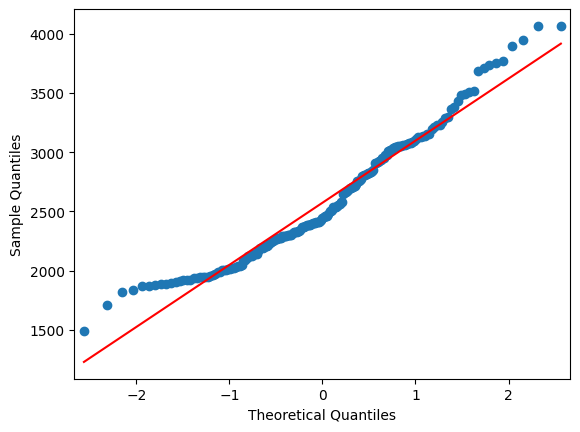

In [109]:
# curbweight
sns.histplot(df[['curbweight']], bins=20, kde=True)
plt.show()

df[['curbweight']].boxplot()
plt.show()

qqplot(df['curbweight'], line='s')
plt.show()

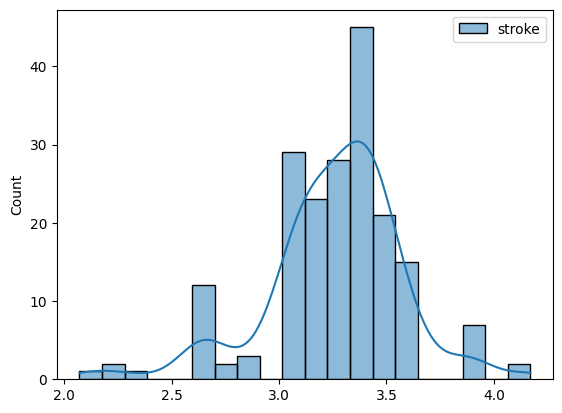

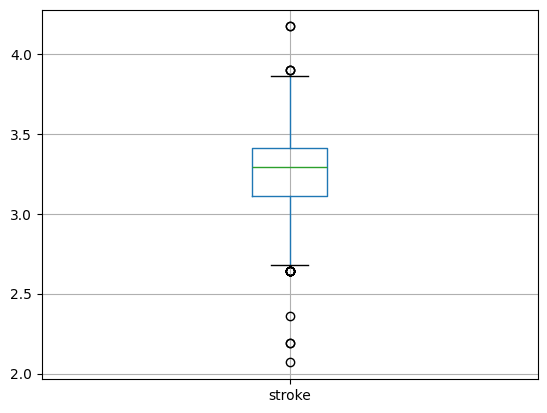

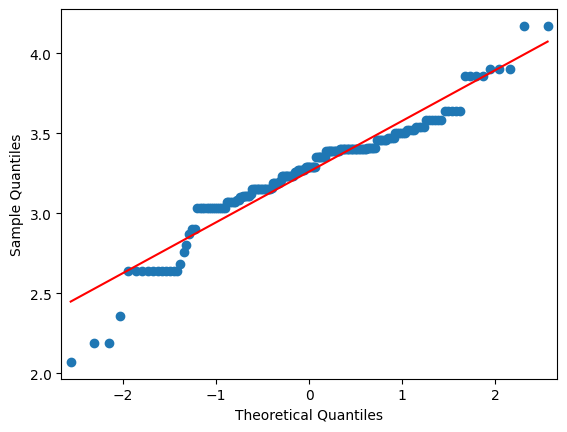

In [110]:
# stroke
sns.histplot(df[['stroke']], bins=20, kde=True)
plt.show()

df[['stroke']].boxplot()
plt.show()

qqplot(df['stroke'], line='s')
plt.show()

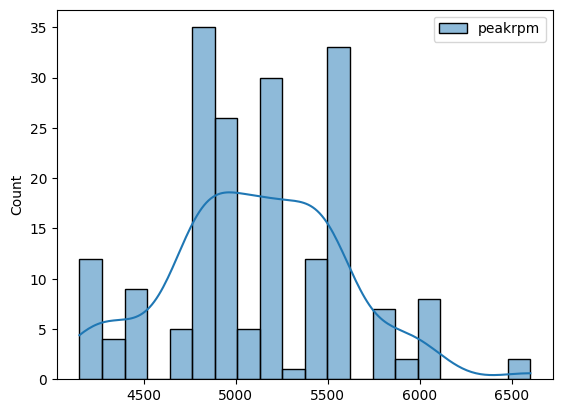

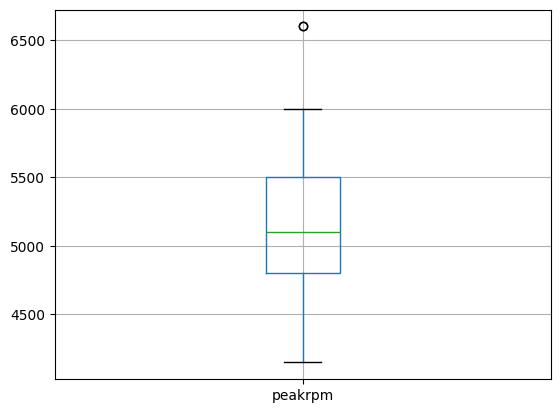

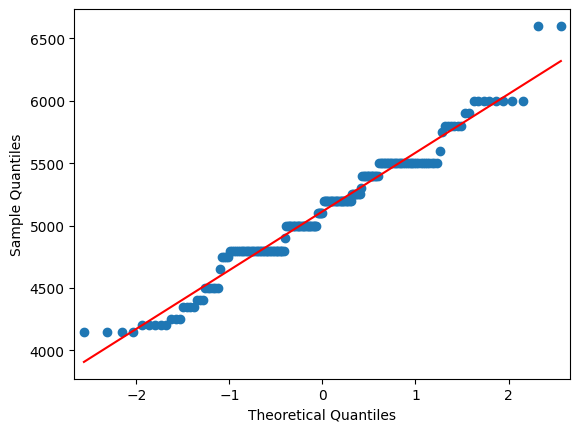

In [111]:
# peakrpm
sns.histplot(df[['peakrpm']], bins=20, kde=True)
plt.show()

df[['peakrpm']].boxplot()
plt.show()

qqplot(df['peakrpm'], line='s')
plt.show()

In [112]:
# Para carwidth', 'stroke', 'peakrpm existem muitos outliers e a distribuição não é normal -> RobustScaler
robust_scaler = RobustScaler()
df['carwidth'], df['stroke'], df['peakrpm'] = robust_scaler.fit_transform(df[['carwidth', 'stroke', 'peakrpm']]).T
df.head()

,aspiration,enginelocation,carwidth,curbweight,enginetype,cylindernumber,stroke,peakrpm,price
0,std,front,-0.518519,2548,dohc,four,-2.033333,-0.142857,expensive
2,std,front,0.000000,2823,ohcv,six,0.600000,-0.142857,expensive
3,std,front,0.000000,2337,ohc,four,0.366667,0.571429,expensive
4,std,front,0.333333,2824,ohc,five,0.366667,0.571429,expensive
5,std,front,0.296296,2507,ohc,five,0.366667,0.571429,expensive


In [113]:
# curbweight não tem outliers e segue uma distribuição normal -> StandardScaler
standard_scaler = StandardScaler()
df['curbweight'] = standard_scaler.fit_transform(df[['curbweight']])
df.head()

,aspiration,enginelocation,carwidth,curbweight,enginetype,cylindernumber,stroke,peakrpm,price
0,std,front,-0.518519,-0.048068,dohc,four,-2.033333,-0.142857,expensive
2,std,front,0.000000,0.476395,ohcv,six,0.600000,-0.142857,expensive
3,std,front,0.000000,-0.450474,ohc,four,0.366667,0.571429,expensive
4,std,front,0.333333,0.478302,ohc,five,0.366667,0.571429,expensive
5,std,front,0.296296,-0.126260,ohc,five,0.366667,0.571429,expensive


## (4) Encoding the categorical features

In [114]:
df.head()

,aspiration,enginelocation,carwidth,curbweight,enginetype,cylindernumber,stroke,peakrpm,price
0,std,front,-0.518519,-0.048068,dohc,four,-2.033333,-0.142857,expensive
2,std,front,0.000000,0.476395,ohcv,six,0.600000,-0.142857,expensive
3,std,front,0.000000,-0.450474,ohc,four,0.366667,0.571429,expensive
4,std,front,0.333333,0.478302,ohc,five,0.366667,0.571429,expensive
5,std,front,0.296296,-0.126260,ohc,five,0.366667,0.571429,expensive


In [115]:
# aspiration e enginelocation -> binários -> oneHotEncoding binário
print(df['aspiration'].unique())
print(df['enginelocation'].unique())

biA_ohe = OneHotEncoder(sparse_output=False, drop='if_binary', categories=[['std', 'turbo']])
biE_ohe = OneHotEncoder(sparse_output=False, drop='if_binary', categories=[['front', 'rear']])

df['aspirationTurbo'] = biA_ohe.fit_transform(df[['aspiration']])
df['engineRear'] = biE_ohe.fit_transform(df[['enginelocation']])

df.drop(columns=['aspiration', 'enginelocation'], inplace=True)
df.head()


['std' 'turbo']
['front' 'rear']


,carwidth,curbweight,enginetype,cylindernumber,stroke,peakrpm,price,aspirationTurbo,engineRear
0,-0.518519,-0.048068,dohc,four,-2.033333,-0.142857,expensive,0.0,0.0
2,0.000000,0.476395,ohcv,six,0.600000,-0.142857,expensive,0.0,0.0
3,0.000000,-0.450474,ohc,four,0.366667,0.571429,expensive,0.0,0.0
4,0.333333,0.478302,ohc,five,0.366667,0.571429,expensive,0.0,0.0
5,0.296296,-0.126260,ohc,five,0.366667,0.571429,expensive,0.0,0.0


In [116]:
# enginetype -> OneHotEncoding
print(df['enginetype'].unique())

E_ohe = OneHotEncoder(sparse_output=False)
E_ohe.fit(df[['enginetype']])

df[E_ohe.get_feature_names_out()] = E_ohe.transform(df[['enginetype']])

df.drop(columns=['enginetype'], inplace=True)

df.head()

['dohc' 'ohcv' 'ohc' 'l' 'rotor' 'ohcf' 'dohcv']


,carwidth,curbweight,cylindernumber,stroke,peakrpm,price,aspirationTurbo,engineRear,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor
0,-0.518519,-0.048068,four,-2.033333,-0.142857,expensive,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.476395,six,0.600000,-0.142857,expensive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.000000,-0.450474,four,0.366667,0.571429,expensive,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.333333,0.478302,five,0.366667,0.571429,expensive,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.296296,-0.126260,five,0.366667,0.571429,expensive,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [117]:
# cylindernumber na verdade já é numero (formato de string: four, five, six) -> OrdinalEncoding manual
print(df['cylindernumber'].unique())
df['cylindernumber'] = df['cylindernumber'].map({'four': 4,
                                                 'six': 6,
                                                 "five":5,
                                                 'three': 3,
                                                 'twelve':12,
                                                 'two':2,
                                                 'eight':8})
print(df['cylindernumber'].unique())
df.head()

['four' 'six' 'five' 'three' 'twelve' 'two' 'eight']
[ 4  6  5  3 12  2  8]


,carwidth,curbweight,cylindernumber,stroke,peakrpm,price,aspirationTurbo,engineRear,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor
0,-0.518519,-0.048068,4,-2.033333,-0.142857,expensive,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.476395,6,0.600000,-0.142857,expensive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.000000,-0.450474,4,0.366667,0.571429,expensive,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.333333,0.478302,5,0.366667,0.571429,expensive,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.296296,-0.126260,5,0.366667,0.571429,expensive,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


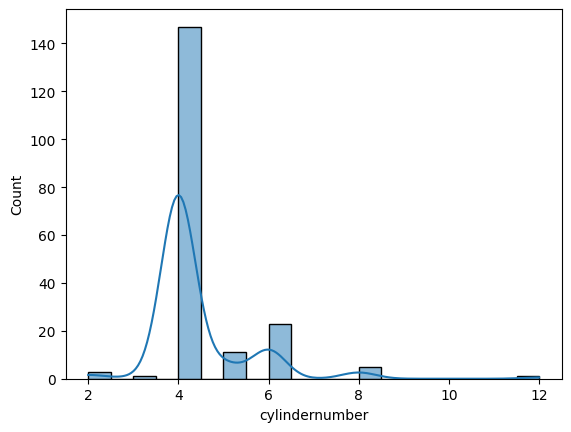

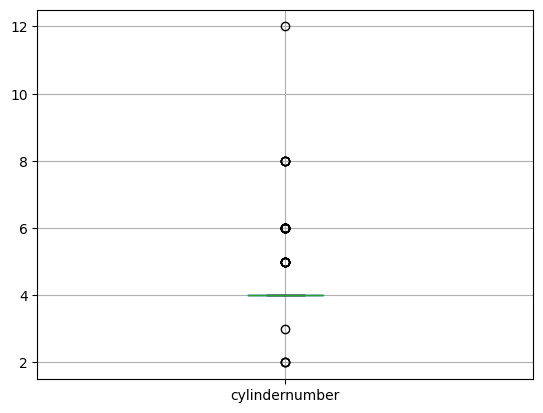

In [118]:
# Scaling cylindernumber?
sns.histplot(df['cylindernumber'], bins=20, kde=True)
plt.show()

df[['cylindernumber']].boxplot()
plt.show()

In [120]:
# Muitos outlers -> RobustScaler
CN_robust_scaler = RobustScaler()
df[['cylindernumber']] = CN_robust_scaler.fit_transform(df[['cylindernumber']])
df.head()

,carwidth,curbweight,cylindernumber,stroke,peakrpm,price,aspirationTurbo,engineRear,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor
0,-0.518519,-0.048068,0.0,-2.033333,-0.142857,expensive,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.476395,2.0,0.600000,-0.142857,expensive,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.000000,-0.450474,0.0,0.366667,0.571429,expensive,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.333333,0.478302,1.0,0.366667,0.571429,expensive,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.296296,-0.126260,1.0,0.366667,0.571429,expensive,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [124]:
# price
label_encoder = LabelEncoder()
df['price'] = label_encoder.fit_transform(df['price'])
df.head()

,carwidth,curbweight,cylindernumber,stroke,peakrpm,price,aspirationTurbo,engineRear,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor
0,-0.518519,-0.048068,0.0,-2.033333,-0.142857,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.476395,2.0,0.600000,-0.142857,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.000000,-0.450474,0.0,0.366667,0.571429,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.333333,0.478302,1.0,0.366667,0.571429,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.296296,-0.126260,1.0,0.366667,0.571429,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## (5) Base Modelling

In [132]:
LR_basemodel = LogisticRegression(max_iter=1000)
X = df.drop(columns=['price'])
y = df['price']
scores = cross_val_score(LR_basemodel, X, y, cv=10)
base_model_score = scores.mean()
print(base_model_score)

0.8797368421052632


## (6) Feature Selection (with _Permutation Importance_)

In [130]:
df.head()

,carwidth,curbweight,cylindernumber,stroke,peakrpm,price,aspirationTurbo,engineRear,enginetype_dohc,enginetype_dohcv,enginetype_l,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor
0,-0.518519,-0.048068,0.0,-2.033333,-0.142857,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.476395,2.0,0.600000,-0.142857,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.000000,-0.450474,0.0,0.366667,0.571429,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.333333,0.478302,1.0,0.366667,0.571429,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,0.296296,-0.126260,1.0,0.366667,0.571429,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [154]:
LR = LogisticRegression(max_iter=1000)
weak_features = ['carwidth', 'cylindernumber', 'stroke', 'peakrpm', 'aspirationTurbo', 'engineRear',  'enginetype_ohcv',
                 'enginetype_dohc', 'enginetype_dohcv', 'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf', 'enginetype_rotor']
X = df.drop(columns=weak_features).drop(columns=['price'])
y = df['price']
scores = cross_val_score(LR, X, y, cv=10)
model_score = scores.mean()
print(model_score)

0.8955263157894737


In [161]:
X = df.drop(columns=['price'])
y = df['price']

LR = LogisticRegression().fit(X, y)

permutation_score = permutation_importance(LR, X, y, n_repeats=100)

importance_df = pd.DataFrame(np.vstack((X.columns, permutation_score.importances_mean)).T)
importance_df.columns=['feature', 'score_decrease']

importance_df.sort_values(by="score_decrease", ascending=False)

,feature,score_decrease
1,curbweight,0.291832
0,carwidth,0.110262
3,stroke,0.032199
11,enginetype_ohcf,0.017906
10,enginetype_ohc,0.015707
4,peakrpm,0.012827
13,enginetype_rotor,0.010733
2,cylindernumber,0.010628
5,aspirationTurbo,0.007487
7,enginetype_dohc,0.005183


In [162]:
threshold = 0.05

weak_features = importance_df[importance_df.score_decrease <= threshold]["feature"].values
weak_features

array(['cylindernumber', 'stroke', 'peakrpm', 'aspirationTurbo',
       'engineRear', 'enginetype_dohc', 'enginetype_dohcv',
       'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf',
       'enginetype_ohcv', 'enginetype_rotor'], dtype=object)

In [163]:
X_strong_features = df.drop(columns=list(weak_features) + ["price"])

print(f"Our strong features are {list(X_strong_features.columns)}")

model = LogisticRegression()

scores = cross_val_score(model, X_strong_features, y, cv = 10)
strong_model_score = scores.mean()
print(strong_model_score)

Our strong features are ['carwidth', 'curbweight']
0.8902631578947368


## Bonus - Stratifying your data ⚖️

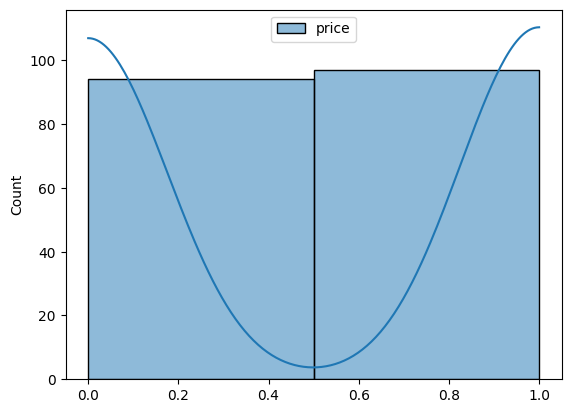

In [169]:
sns.histplot(df[['price']], bins=2, kde=True)
plt.show()

In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print('Training data share of class 1 cars:', y_train.mean())
print('Testing data share of class 1 cars:', y_test.mean())

Training data share of class 1 cars: 0.5037593984962406
Testing data share of class 1 cars: 0.5172413793103449


In [171]:
for i in range(1, 11):
    print("-"*50)
    print("##### Random state set =", i)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    print('Training data share of class 1 cars:', round(y_train.mean(), 3))
    print('Testing data share of class 1 cars:', round(y_test.mean(), 3))

--------------------------------------------------
##### Random state set = 1
Training data share of class 1 cars: 0.504
Testing data share of class 1 cars: 0.517
--------------------------------------------------
##### Random state set = 2
Training data share of class 1 cars: 0.481
Testing data share of class 1 cars: 0.569
--------------------------------------------------
##### Random state set = 3
Training data share of class 1 cars: 0.504
Testing data share of class 1 cars: 0.517
--------------------------------------------------
##### Random state set = 4
Training data share of class 1 cars: 0.534
Testing data share of class 1 cars: 0.448
--------------------------------------------------
##### Random state set = 5
Training data share of class 1 cars: 0.534
Testing data share of class 1 cars: 0.448
--------------------------------------------------
##### Random state set = 6
Training data share of class 1 cars: 0.496
Testing data share of class 1 cars: 0.534
----------------------

In [172]:
model_1 = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

model_1.fit(X_train, y_train)

model_1.score(X_test, y_test)

0.9310344827586207

In [173]:
model_9 = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9)

model_9.fit(X_train, y_train)

model_9.score(X_test, y_test)

0.7931034482758621

In [174]:
for i in range(1, 11):
    print("-"*50)
    print("##### Random state set =", i)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i, stratify=y)
    print('Training data share of class 1 cars:', round(y_train.mean(), 3))
    print('Testing data share of class 1 cars:', round(y_test.mean(), 3))

--------------------------------------------------
##### Random state set = 1
Training data share of class 1 cars: 0.511
Testing data share of class 1 cars: 0.5
--------------------------------------------------
##### Random state set = 2
Training data share of class 1 cars: 0.511
Testing data share of class 1 cars: 0.5
--------------------------------------------------
##### Random state set = 3
Training data share of class 1 cars: 0.511
Testing data share of class 1 cars: 0.5
--------------------------------------------------
##### Random state set = 4
Training data share of class 1 cars: 0.511
Testing data share of class 1 cars: 0.5
--------------------------------------------------
##### Random state set = 5
Training data share of class 1 cars: 0.511
Testing data share of class 1 cars: 0.5
--------------------------------------------------
##### Random state set = 6
Training data share of class 1 cars: 0.511
Testing data share of class 1 cars: 0.5
----------------------------------

In [179]:
X = df.drop(columns=['price'])

# initializing a stratified k-fold that will split the data into 5 folds
skf = StratifiedKFold(n_splits=5)
scores = []

# .split() method creates an iterator; 'X.aspiration' is the feature that we stratify by
for train_indices, test_indices in skf.split(X, X.aspirationTurbo):
    # 'train_indices' and 'test_indices' are lists of indices that produce proportional splits
    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

    # initialize and fit a model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # append a score to get an average of 5 folds in the end
    scores.append(model.score(X_test, y_test))

np.array(scores).mean()

np.float64(0.8585695006747638)